In [1]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
from traj_run import rho_ohmic, check_onestep
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
# import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, draw_t_I,  wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter, \
    show_result_t_I, dof_name_gentor_S, dof_name_gentor_I, get_near_zero_timestamp, get_min_timestamp

from scipy.optimize import curve_fit

from traj_run import check_onestep

2024-10-23 16:50:30,102[INFO] Use NumPy as backend
2024-10-23 16:50:30,102[INFO] numpy random seed is 9012
2024-10-23 16:50:30,103[INFO] random seed is 1092
2024-10-23 16:50:30,104[INFO] Git Commit Hash: d897b277e9ff95f70c482307f2a5078cb59cac6a
2024-10-23 16:50:30,104[INFO] use 64 bits


In [2]:
I_folder = '/home/ansatz/data/comp/sbm/24_09_27'
S_folder = '/home/ansatz/data/comp/sbm/24_09_28'
nsteps = 500

In [3]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(S_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    key = line
    # print(key)
    vn_entropy_1site_all_lines[key] = points
print('-----')
mutual_infos_all_lines ={}
for line in sorted([ s for s in os.listdir(I_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    points = { i_step : f'{i_step:04}_step_mutual_infos.pickle' for i_step in range(nsteps) }

    key = line
    # print(key)
    mutual_infos_all_lines[key] = points

-----
-----


In [4]:
for key in vn_entropy_1site_all_lines.keys():
    print(key)
for key in mutual_infos_all_lines.keys():
    print(key)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [5]:


def r_squared(x,y, param_list, func):
    mean = np.mean(y)  # 1.y mean

    ss_tot = np.sum((y - mean) ** 2)  # 2.total sum of squares

    ss_res = np.sum((y - func(x, *param_list)) ** 2)  # 3.residual sum of squares

    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [6]:

def get_freq_cft_xf_yf(mother_folder, data_dict,\
                  s=0.7, alpha=0.4, nmodes=1000, rho_type=0, nsteps=100, dof_name=dof_name_gentor_S,
                  idof=504):
    v_dof = data = get_data_of_dof(mother_folder=mother_folder, data_dict=data_dict,\
                  s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, dof_name=dof_name, 
                  
                  idof=idof)
    signal = wavelet_denoising(v_dof)
    N = 1001
    xf, yf = do_cft(np.linspace(0, 10, 100), signal, N)

    plt.clf()

In [7]:
s=0.1
alpha=0.15
nmodes=1000
rho_type=0
nsteps=500   
dt = 0.1
nmodes = 1000
job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
key =job_name

# pf = os.path.join(S_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')



# omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)

In [8]:
ids = [ i for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
draw_ids = []
for i in range(11):
    draw_ids.append(ids[i*10])
draw_ids
ids

[99,
 104,
 109,
 114,
 119,
 124,
 129,
 134,
 139,
 144,
 149,
 154,
 159,
 164,
 169,
 174,
 179,
 184,
 189,
 194,
 199,
 204,
 209,
 214,
 219,
 224,
 229,
 234,
 239,
 244,
 249,
 254,
 259,
 264,
 269,
 274,
 279,
 284,
 289,
 294,
 299,
 304,
 309,
 314,
 319,
 324,
 329,
 334,
 339,
 344,
 349,
 354,
 359,
 364,
 369,
 374,
 379,
 384,
 389,
 394,
 399,
 404,
 409,
 414,
 419,
 424,
 429,
 434,
 439,
 444,
 449,
 454,
 459,
 464,
 469,
 474,
 479,
 484,
 489,
 494,
 499,
 504,
 509,
 514,
 519,
 524,
 529,
 534,
 539,
 544,
 549,
 554,
 559,
 564,
 569,
 574,
 579,
 584,
 589,
 594,
 599,
 604,
 609,
 614,
 619,
 624,
 629]

([99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599],
 [1.0524952170688262,
  1.623426507418465,
  2.228938322468614,
  2.873491275510858,
  3.562468922806306,
  4.302451371066512,
  5.1015984478001295,
  5.97019970162306,
  6.921486782303557,
  7.972874398125423,
  9.147933520086514],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
         4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
  array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
         4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
  array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
         4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
  array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
         4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
  array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
         4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
  array([0.00000000e+00, 3.335557

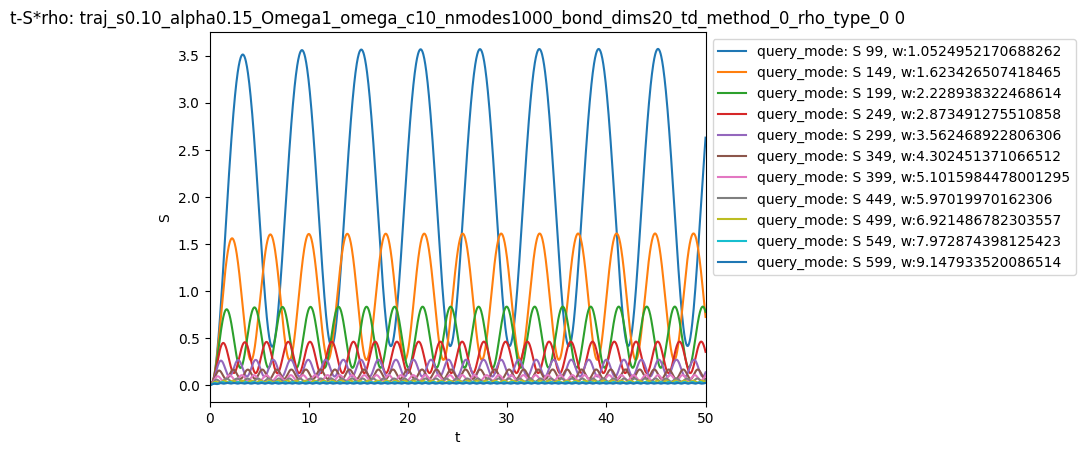

In [9]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines,\
                          s, alpha, query_modes=draw_ids, nmodes=nmodes, rho_type=0, nstep=nsteps)

In [10]:
timestamps = get_near_zero_timestamp(S_folder, vn_entropy_1site_all_lines,\
                          s, alpha, ids, nmodes=nmodes, rho_type=0, nsteps=nsteps, dof_name=dof_name_gentor_S)

In [11]:
import pickle

In [12]:
for key in vn_entropy_1site_all_lines.keys():
    print(key)
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    timestamps = get_min_timestamp(S_folder, vn_entropy_1site_all_lines,\
                          s, alpha, ids, nmodes=nmodes, rho_type=0, nsteps=nsteps, dof_name=dof_name_gentor_S)
    with open (os.path.join('configs', f'{key}.pickle'), 'wb') as f:
        pickle.dump(timestamps, f)
    # check_onestep

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [13]:
for key in mutual_infos_all_lines.keys():
    print(key)
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    timestamps = get_near_zero_timestamp(I_folder, mutual_infos_all_lines,\
                          s, alpha, ids, nmodes=nmodes, rho_type=0, nsteps=nsteps, dof_name=dof_name_gentor_I)
    with open (os.path.join('configs', f'{key}.pickle'), 'wb') as f:
        pickle.dump(timestamps, f)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [14]:
key

'traj_s0.70_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0'

In [15]:
with open (os.path.join('configs', f'{key}.pickle'), 'rb') as f:
        dat = pickle.load( f)

In [16]:
dat

{('spin',
  'v_99'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25]),
 ('spin',
  'v_104'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25]),
 ('spin',
  'v_109'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('spin',
  'v_114'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('spin',
  'v_119'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('s

In [17]:
current_time = 0

future_time = current_time + dt 

rtol=1e-7
atol=0

In [18]:
dat

{('spin',
  'v_99'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25]),
 ('spin',
  'v_104'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25]),
 ('spin',
  'v_109'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('spin',
  'v_114'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('spin',
  'v_119'): array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 ('s

In [19]:
dt =0.1

In [20]:
for key in mutual_infos_all_lines.keys():
    print(key)
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    timestamps = get_min_timestamp(I_folder, mutual_infos_all_lines,\
                          s, alpha, ids, nmodes=nmodes, rho_type=0, nsteps=nsteps, dof_name=dof_name_gentor_I)
    for i in range(500):
        current_time = i *dt
        future_time = current_time + dt
        dynamic_steps, static_steps = check_onestep(timestamps, current_time, future_time, dt=dt, dynamic_num=1)
    # current_time = current_time + dt
    # future_time = future_time + dt
        if not(len(dynamic_steps) == 0 and len(static_steps) == 0):
            if len(dynamic_steps) != 0 :
                print(i, dynamic_steps, static_steps)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [21]:
np.isclose([0.011],[0.0], rtol=0, atol=0.01,equal_nan=True)

array([False])

In [22]:
np.isclose([0.01], [0], rtol=0, atol=1e-4)

array([False])

In [24]:

for i in range(500):
    current_time = i *dt
    future_time = current_time + dt
    token_dict, static_steps = check_onestep(timestamps, current_time, future_time)
    # current_time = current_time + dt
    # future_time = future_time + dt
    if not(len(token_dict) == 0 and len(static_steps) == 0):
        print(i, token_dict, static_steps)

6 {9: [('spin', 'v_604')], 7: [('spin', 'v_609'), ('spin', 'v_614')], 8: [('spin', 'v_609')], 6: [('spin', 'v_614'), ('spin', 'v_619')], 5: [('spin', 'v_619'), ('spin', 'v_624')], 4: [('spin', 'v_624'), ('spin', 'v_629')], 3: [('spin', 'v_629')]} [('spin', 'v_599')]
7 {8: [('spin', 'v_559')], 7: [('spin', 'v_564')], 5: [('spin', 'v_569'), ('spin', 'v_574')], 6: [('spin', 'v_569')], 4: [('spin', 'v_574'), ('spin', 'v_579')], 3: [('spin', 'v_579'), ('spin', 'v_584')], 1: [('spin', 'v_589'), ('spin', 'v_594')], 2: [('spin', 'v_589')]} []
8 {9: [('spin', 'v_514'), ('spin', 'v_519')], 8: [('spin', 'v_519'), ('spin', 'v_524')], 7: [('spin', 'v_524')], 5: [('spin', 'v_529')], 6: [('spin', 'v_529')], 4: [('spin', 'v_534')], 3: [('spin', 'v_539')], 2: [('spin', 'v_544')], 1: [('spin', 'v_549')]} []
9 {9: [('spin', 'v_479'), ('spin', 'v_484')], 8: [('spin', 'v_484')], 6: [('spin', 'v_489')], 7: [('spin', 'v_489')], 4: [('spin', 'v_494')], 5: [('spin', 'v_494')], 3: [('spin', 'v_499'), ('spin', '

In [26]:
i = 6
current_time = i *dt
future_time = current_time + dt
token_dict, static_steps = check_onestep(timestamps, current_time, future_time)
current_time = current_time + dt
future_time = future_time + dt
if not(len(token_dict) == 0 and len(static_steps) == 0):
    print(i, token_dict, static_steps)

6 {9: [('spin', 'v_604')], 7: [('spin', 'v_609'), ('spin', 'v_614')], 8: [('spin', 'v_609')], 6: [('spin', 'v_614'), ('spin', 'v_619')], 5: [('spin', 'v_619'), ('spin', 'v_624')], 4: [('spin', 'v_624'), ('spin', 'v_629')], 3: [('spin', 'v_629')]} [('spin', 'v_599')]


In [28]:
current_time = 467 *dt
future_time = current_time + dt
token_dict, static_steps = check_onestep(timestamps, current_time, future_time)

In [31]:
times = timestamps[('spin', 'v_149')]
a = times  < future_time
b = times  > current_time

In [32]:
np.where(a[-1] == times)

(array([], dtype=int64),)

In [34]:

a = np.isclose(6.3, 6.4, rtol=rtol, atol=atol,
                                       equal_nan=True)

In [36]:
track_points = timestamps[dof_name_gentor_I(99)]

 you need to learn who is who

In [37]:
track_points

array([ 6.1 , 12.08, 18.06, 24.04, 30.02, 36.  , 41.98, 47.96])

In [39]:
s=0.4
alpha=0.30
nmodes=1000
rho_type=0
nsteps=500   
dt = 0.1
nmodes = 1000
job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
key =job_name

In [40]:
ids = [ i for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
draw_ids = []
for i in range(6):
    draw_ids.append(ids[i*20])

draw_ids

[99, 199, 299, 399, 499, 599]

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

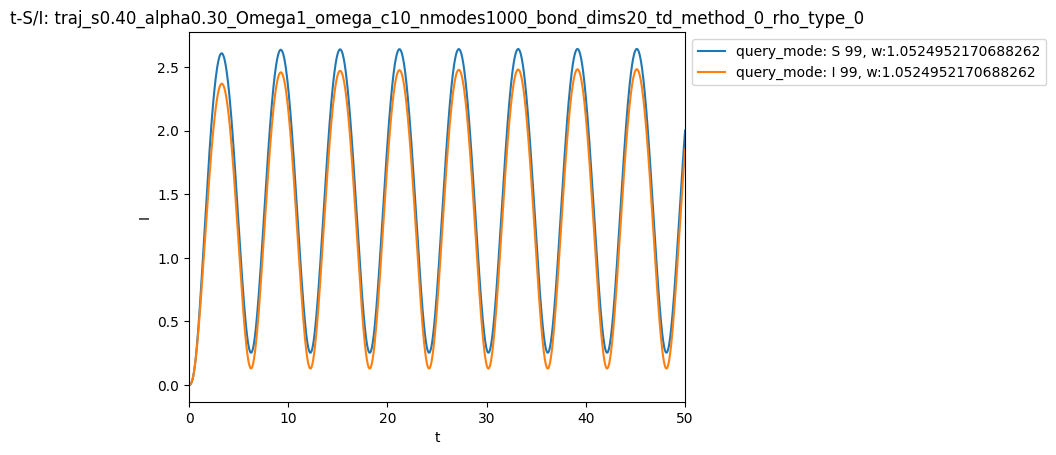

In [41]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[:1], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[:1], nstep=500)

plt.title(f't-S/I: {key}')

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

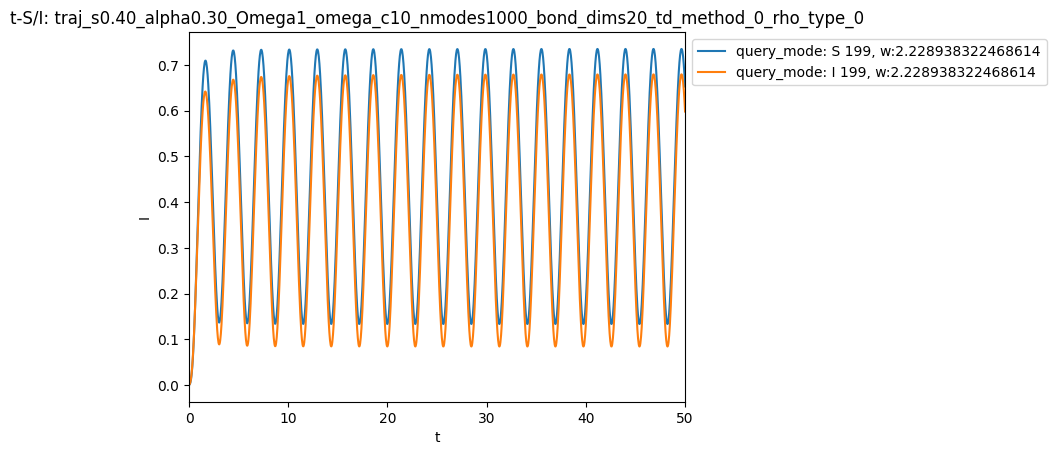

In [42]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[1:2], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[1:2], nstep=500)
plt.title(f't-S/I: {key}')

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

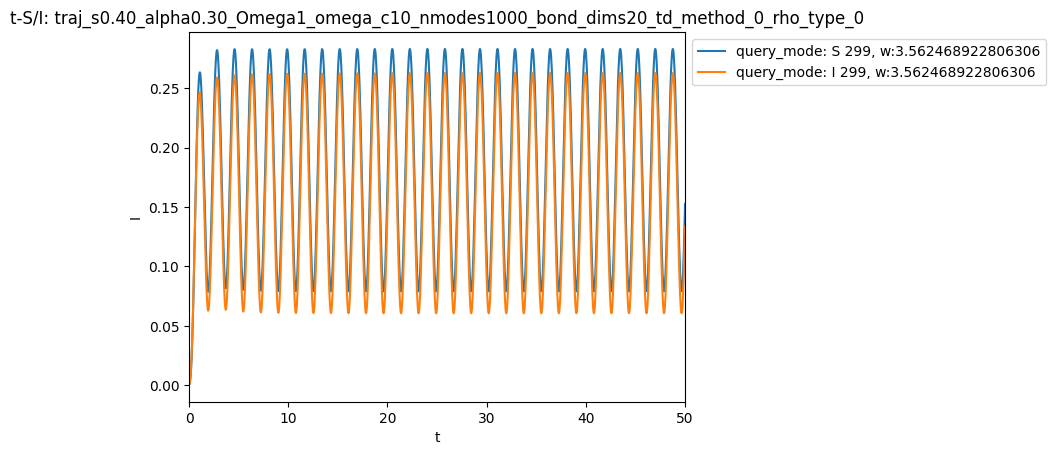

In [43]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[2:3], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[2:3], nstep=500)
plt.title(f't-S/I: {key}')

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

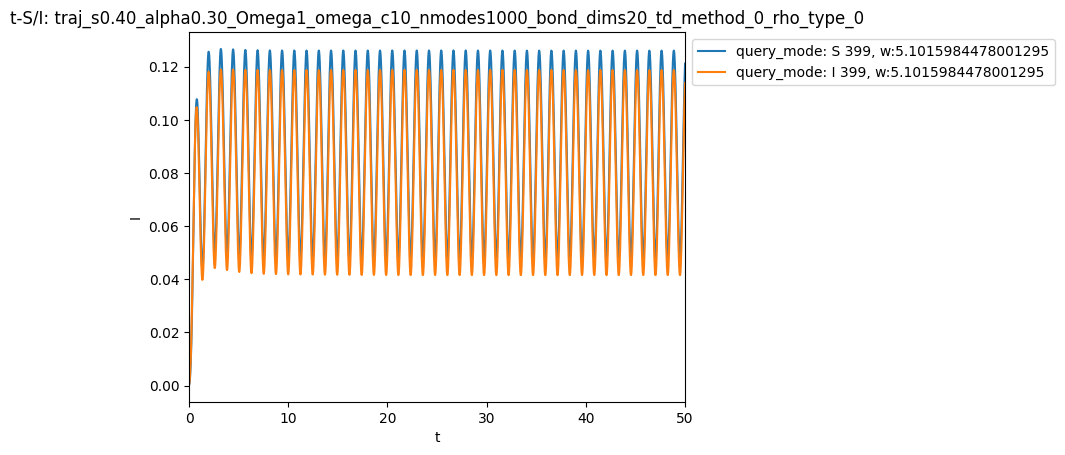

In [44]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[3:4], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[3:4], nstep=500)
plt.title(f't-S/I: {key}')

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

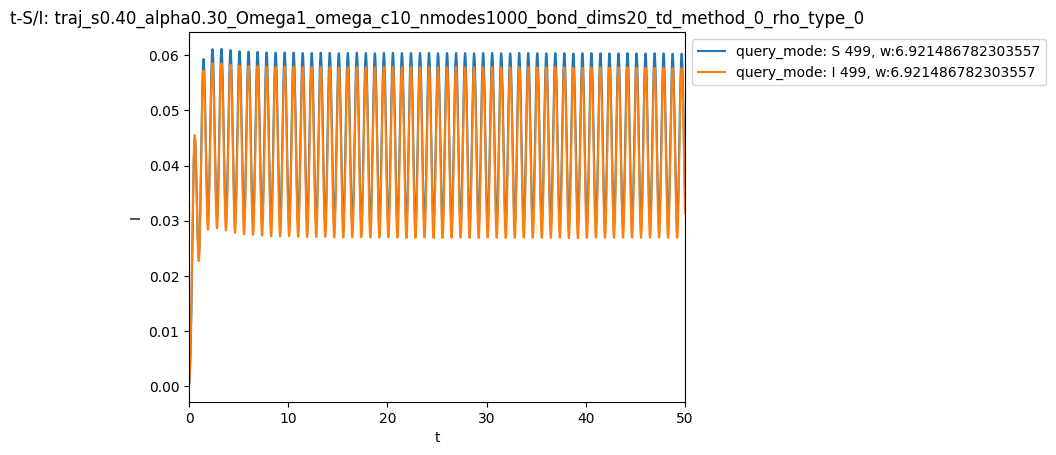

In [45]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[4:5], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[4:5], nstep=500)
plt.title(f't-S/I: {key}')

Text(0.5, 1.0, 't-S/I: traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0')

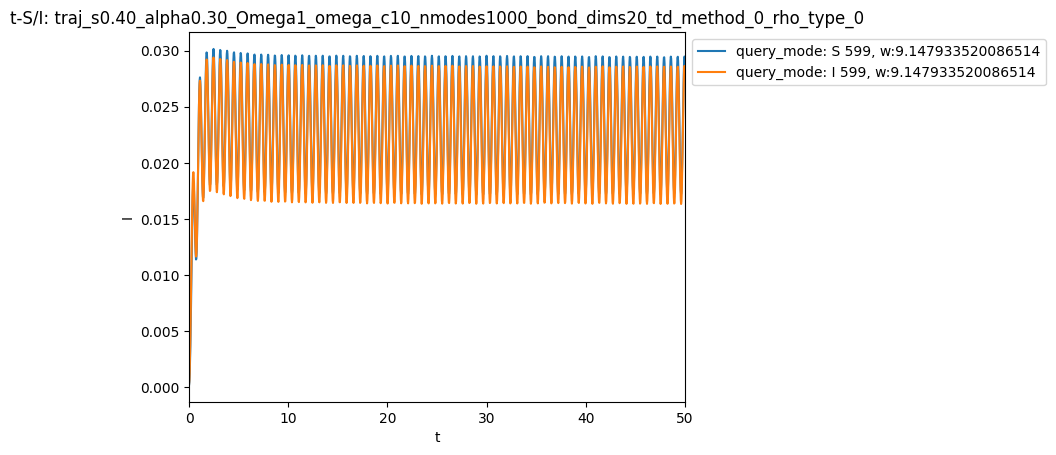

In [46]:
show_result_t_S(S_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids[5:6], nstep=500)
show_result_t_I(I_folder, mutual_infos_all_lines, s, alpha, query_modes=draw_ids[5:6], nstep=500)
plt.title(f't-S/I: {key}')